In [120]:
import re
import json
import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
#HELPER FUNCTIONS
def get_addr_data(json_dataset):
    """
    # info on available address fields ( and how are they used )
    # export addr data to pandas-dataset [ element-id, addr-field, addr-field-val ]
    #   run analysis of the dataset
    """
    data_header = ['node_id', 'node_type', 'tag', 'val']
    raw_data = []
    for json_node in json_dataset:
        if 'address' in json_node:
            for tag in json_node['address']:
                raw_data.append([
                    json_node['id'],
                    json_node['type'],
                    tag,
                    json_node['address'][tag]
                ])
        else:
            raw_data.append([
                json_node['id'],
                json_node['type'],
                None,
                None
            ])
    return pd.DataFrame(raw_data, columns=data_header)




In [107]:
#CONST DEFINITIONS
DATA_SOURCE='..\sample-100-redwood-city-ca.osm.json'

#LOADING DATA
parsed_json_data = []
for line in open(DATA_SOURCE, 'r'):
    parsed_json_data.append(json.loads(line))
    
data_df = get_addr_data(parsed_json_data)

data_addr_df = data_df[pd.notnull(data_df['tag'])]

In [98]:
data_addr_df.head()

,node_id,node_type,tag,val
98,1337779743,node,housenumber,66
143,1438723123,node,housenumber,355
179,1599245638,node,housenumber,70
181,1641208803,node,housenumber,805
184,1733719626,node,city,Redwood City


In [108]:
print "Number of nodes: %d" % len(data_addr_df['node_id'].unique())
print "Listing the unique address tags:"
print data_addr_df['tag'].unique()
print data_addr_df['tag'].describe()

Number of nodes: 442
Listing the unique address tags:
[u'state' u'city' u'street' u'housenumber' u'postcode' u'unit' u'country'
 u'county']
count             988
unique              8
top       housenumber
freq              383
Name: tag, dtype: object


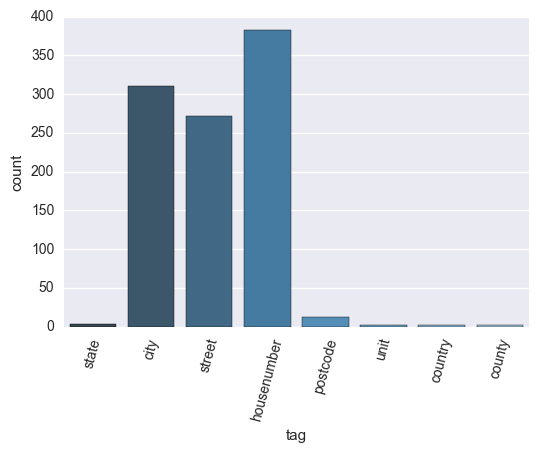

In [133]:
#Investigating the number of tags associated with addresses
sns.countplot ( data_addr_df['tag'] , palette='Blues_d')
ticks = plt.xticks(rotation=75)

In [127]:
UNIQUE_CHECK_EXCLUDE = ['street', 'housenumber', 'unit']
tags_to_check =  data_addr_df['tag'].unique()
for tag in tags_to_check:
    if tag in UNIQUE_CHECK_EXCLUDE:
        continue
    else:
        print "[%s] UNIQUE VALUE CHECK" % tag
        print data_addr_df[data_addr_df['tag'] == tag]['val'].unique()

[state] UNIQUE VALUE CHECK
[u'CA']
[city] UNIQUE VALUE CHECK
[u'Redwood City' u'Palo Alto' u'San Mateo' u'Menlo Park']
[postcode] UNIQUE VALUE CHECK
[u'94063' u'94061' u'94403' u'94025']
[country] UNIQUE VALUE CHECK
[u'US']
[county] UNIQUE VALUE CHECK
[u'San Mateo' u'Santa Clara']


In [141]:
#Investigate street names
#  compiling re outside of lambda for better performance
street_type_re = re.compile('.*\s(?P<street_type>[^\s]+)\s*$')

def get_street_type(df_row, street_type_re):
    street_full_name = df_row['val']
    street_type_match = street_type_re.match(street_full_name)
    if street_type_match:
        return street_type_match.group('street_type')
    else:
        return street_full_name
    
street_data_df = data_addr_df[data_addr_df['tag'] == 'street'].copy()
street_data_df['st_type'] = street_data_df.apply( lambda row : get_street_type(row, street_type_re), axis=1)


print street_data_df.head()
street_data_df.groupby(['st_type'])['st_type'].count()

         node_id node_type     tag             val st_type
369    568039228      node  street     Main Street  Street
561   1251606827      node  street  El Camino Real    Real
1432  1437035490      node  street   George Avenue  Avenue
1831  1669545524      node  street  El Camino Real    Real
1845  1705316233      node  street   Woodside Road    Road


st_type
Alameda       6
Avenue       89
Boulevard     2
Broadway      5
Court         2
Drive        20
Lane          9
Oakridge      1
Place         7
Plz           1
Real          5
Road         30
Street       79
Way          16
Name: st_type, dtype: int64

In [147]:
#Printing out entries with not expected street type
def hasnot_expected_street_type(street_name):
    street_type_expected = ['Avenue', 'Boulevard', 'Court', 'Drive', 'Lane', 'Road', 'Street', 'Way', 'Place']
    for st_type in street_type_expected:
        if street_name.rstrip().endswith(st_type):
            return False
    return True

street_data_nonexpected_index = street_data_df['val'].map( hasnot_expected_street_type ) 

street_data_df[ street_data_nonexpected_index ]['val'].unique()


array([u'El Camino Real', u'Broadway', u'Woodside Plz', u'Alameda',
       u'Oakridge'], dtype=object)